# Dog bread classification using AWS Sagemaker

In [40]:
!pip install smdebug
!pip install sagemaker -U


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [4]:
import sagemaker
import boto3
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.pytorch import PyTorch
from sagemaker.pytorch import PyTorchModel

from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    rule_configs,
    ProfilerRule,
    CollectionConfig,
    ProfilerConfig,
    FrameworkProfile
)

import os
import IPython
import matplotlib.pyplot as plt

## 1. Dataset

Download the data from udacity S3 bucket to local and upload it to my personal S3 bucket

In [ ]:
# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2023-03-17 00:03:49--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.193.0
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.193.0|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip.1’

dogImages.zip.1     100%[===================>]   1.05G  20.8MB/s    in 38s     

2023-03-17 00:04:28 (28.4 MB/s) - ‘dogImages.zip.1’ saved [1132023110/1132023110]

Archive:  dogImages.zip
replace dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [136]:
!aws s3 sync dogImages s3://project3-files/dogImages

Create data channel variable for model and tuner fitting.

In [5]:
BUCKET = "project3-files"

In [6]:
data_channels = {
    "train": f"s3://{BUCKET}/dogImages/train/",
    "test": f"s3://{BUCKET}/dogImages/test/",
    "valid": f"s3://{BUCKET}/dogImages/valid/"
}

In [7]:
role = sagemaker.get_execution_role()

## 2. Hyperparameter Tuning

The following hyperparameters were tuned: `Learning Rate`, `Batch Size` and `Number of Epochs`.

In [122]:
# setup hyperparameters
hyperparameters = {
    "lr": ContinuousParameter(0.001, 0.01),
   "batch-size": CategoricalParameter([32, 64]),
}

The objective of the model training is to `minimize` the loss. In this case, `average test loss` was used.

In [123]:
# debugger objectives
objective_metric_name = "validation:acc"
objective_type = "Maximize"
metric_definitions = [{"Name": objective_metric_name, "Regex": "Valid set: Accuracy: ([0-9\\.]+)"}]

`Pytorch` estimator was defined and the `HyperparameterTuner` was created.

In [124]:
estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name="dog-bread-pytorch",
    role=role,
    instance_count=3,
    instance_type="ml.m5.2xlarge",
    framework_version="1.8",
    py_version="py36"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameters,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

Train the `tuner` to tune the hyperparameters.

In [125]:
tuner.fit(data_channels,
          wait=True) 

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: pytorch-training-230331-2013


............................................................................................................................................................................................................................................................................................................................!


In [126]:
# Get the best estimator
best_estimator = tuner.best_estimator()

# Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2023-03-31 20:28:40 Starting - Preparing the instances for training
2023-03-31 20:28:40 Downloading - Downloading input data
2023-03-31 20:28:40 Training - Training image download completed. Training in progress.
2023-03-31 20:28:40 Uploading - Uploading generated training model
2023-03-31 20:28:40 Completed - Resource reused by training job: pytorch-training-230331-2013-003-2f6fa9c2


{'_tuning_objective_metric': '"validation:acc"',
 'batch-size': '"64"',
 'lr': '0.0015370630576149785',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"dog-bread-pytorch-2023-03-31-20-13-51-896"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-655329371831/dog-bread-pytorch-2023-03-31-20-13-51-896/source/sourcedir.tar.gz"'}

In [127]:
import pandas as pd
tuner_result = sagemaker.HyperparameterTuningJobAnalytics("pytorch-training-230328-1728")

full_df = tuner_result.dataframe()

if len(full_df) > 0:
    df = full_df[full_df["FinalObjectiveValue"] > -float("inf")]
    if len(df) > 0:
        df = df.sort_values("FinalObjectiveValue")
        print("Number of training jobs with valid objective: %d" % len(df))
        print({"lowest": min(df["FinalObjectiveValue"]), "highest": max(df["FinalObjectiveValue"])})
        pd.set_option("display.max_colwidth", None)  # Don't truncate TrainingJobName
    else:
        print("No training jobs have reported valid results yet.")

df

Number of training jobs with valid objective: 4
{'lowest': 4.696599960327148, 'highest': 4.846499919891357}


,batch-size,epochs,lr,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
1,"""32""",16.0,0.004530,pytorch-training-230328-1728-003-993f0ebe,Completed,4.6966,2023-03-28 18:03:58+00:00,2023-03-28 18:47:48+00:00,2630.0
2,"""32""",16.0,0.003508,pytorch-training-230328-1728-002-4f2a4878,Completed,4.7643,2023-03-28 17:29:41+00:00,2023-03-28 18:14:05+00:00,2664.0
0,"""32""",12.0,0.003101,pytorch-training-230328-1728-004-a0280509,Completed,4.8150,2023-03-28 18:16:21+00:00,2023-03-28 18:50:07+00:00,2026.0
3,"""32""",11.0,0.001760,pytorch-training-230328-1728-001-f8d34995,Completed,4.8465,2023-03-28 17:29:37+00:00,2023-03-28 18:01:18+00:00,1901.0


## 3. Model Profiling and Debugging


In [8]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [9]:
output_path = f"s3://{BUCKET}/outputs/"

In [10]:
hook_config = DebuggerHookConfig(
    s3_output_path=output_path,
    collection_configs=[
        CollectionConfig(
            name="CrossEntropyLoss_output",
            parameters={"include_regex":"CrossEntropyLoss_output",
                        "train.save_interval": "1", 
                        "eval.save_interval": "1",
                        "predict.save_interval": "1"
            }
        )
    ],
    hook_parameters={
        "train.save_interval": "5",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

In [14]:
hyperparameters = {"lr":"0.0015370630576149785",
                   "batch-size":"64"
                  }

In [15]:
estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="smdebugger-dog-bread-pytorch",
    role=role,
    hyperparameters=hyperparameters,
    instance_count=2,
    instance_type="ml.m5.2xlarge",
    framework_version="1.11.0",
    py_version="py38",
    output_path=output_path,
    # rules and hooks 
    rules=rules,
    debugger_hook_config=hook_config,
    env={'MMS_DEFAULT_RESPONSE_TIMEOUT': '10800'}
)

In [ ]:
estimator.fit(data_channels,
              wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: smdebugger-dog-bread-pytorch-2023-04-02-22-29-35-210


2023-04-02 22:29:43 Starting - Starting the training job...
2023-04-02 22:30:12 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2023-04-02 22:31:12 Downloading - Downloading input data......
2023-04-02 22:32:13 Training - Downloading the training image.....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-04-02 18:32:57,891 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-04-02 18:32:57,893 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-04-02 18:32:57,895 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-04-02 18:32:57,905 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-04-02 18:32:57,907 sagemaker_pyto

In [17]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:root:Using NamedTuple = typing._NamedTuple instead.


[2023-04-03 00:42:02.533 pytorch-1-13-gpu-py39-ml-t3-medium-df09acd158cd021541f2bd4aac71:19 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-04-03 00:42:02.546 pytorch-1-13-gpu-py39-ml-t3-medium-df09acd158cd021541f2bd4aac71:19 INFO s3_trial.py:42] Loading trial debug-output at path s3://project3-files/outputs/smdebugger-dog-bread-pytorch-2023-04-02-22-29-35-210/debug-output
[2023-04-03 00:42:03.313 pytorch-1-13-gpu-py39-ml-t3-medium-df09acd158cd021541f2bd4aac71:19 WARNING s3handler.py:184] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 4348 more expected)', IncompleteRead(0 bytes read, 4348 more expected)) while reading s3://project3-files/outputs/smdebugger-dog-bread-pytorch-2023-04-02-22-29-35-210/debug-output/index/000000000/000000000000_worker_0.json . Will retry now


In [18]:
trial

[2023-04-03 00:42:58.991 pytorch-1-13-gpu-py39-ml-t3-medium-df09acd158cd021541f2bd4aac71:19 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2023-04-03 00:43:00.019 pytorch-1-13-gpu-py39-ml-t3-medium-df09acd158cd021541f2bd4aac71:19 INFO trial.py:210] Loaded all steps


<smdebug.trials.s3_trial.S3Trial object at 0x7fb372674220>:(
    name=debug-output,
    path=s3://project3-files/outputs/smdebugger-dog-bread-pytorch-2023-04-02-22-29-35-210/debug-output/,
    steps=[0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99, 101, 103, 105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 127, 129, 131, 133, 135, 137, 139, 141, 143, 145, 147, 149, 151, 153, 155, 157, 159, 161, 163, 165, 167, 169, 171, 173, 175, 177, 179, 181, 183, 185, 187, 189, 191, 193, 195, 197, 199, 201, 203, 205, 207, 209, 210, 211, 213, 215, 217, 219, 221, 223, 225, 227, 229, 231, 233, 235, 237, 239, 241, 243, 245, 247, 249, 251, 253, 255, 257, 259, 261, 263, 265, 267, 269, 271, 273, 275, 277, 279, 281, 283, 285, 287, 289, 291, 293, 295, 297, 299, 301, 303, 305, 307, 309, 311, 313, 315, 317, 319, 321, 323, 325, 327, 329, 331, 333, 335, 337, 33

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


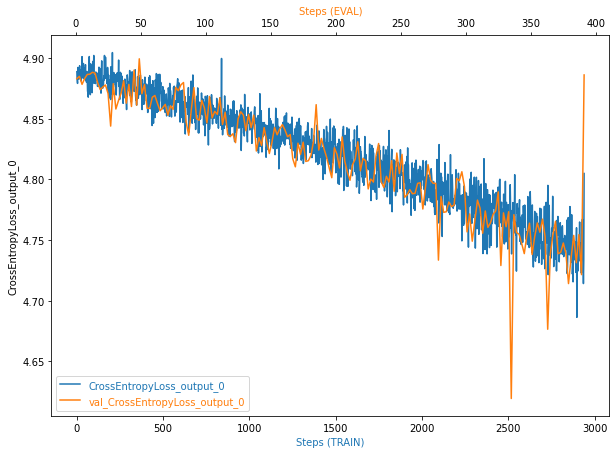

In [20]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

Based on the model training and validation error plot, both errors are decreasing. This means that there's a potential to reduce the error and increase the accuracy. We only trained the model for 16 epochs. More epochs are needed to reduce the error.

In [21]:
# Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [22]:
! aws s3 ls {rule_output_path} --recursive

2023-04-03 00:33:00     330071 outputs/smdebugger-dog-bread-pytorch-2023-04-02-22-29-35-210/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-04-03 00:32:59     171456 outputs/smdebugger-dog-bread-pytorch-2023-04-02-22-29-35-210/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-04-03 00:32:55        193 outputs/smdebugger-dog-bread-pytorch-2023-04-02-22-29-35-210/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-04-03 00:32:55        201 outputs/smdebugger-dog-bread-pytorch-2023-04-02-22-29-35-210/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-04-03 00:32:55        126 outputs/smdebugger-dog-bread-pytorch-2023-04-02-22-29-35-210/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-04-03 00:32:55        127 outputs/smdebugger-dog-bread-pytorch-2023-04-02-22-29-35-210/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-0

In [23]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://project3-files/outputs/smdebugger-dog-bread-pytorch-2023-04-02-22-29-35-210/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://project3-files/outputs/smdebugger-dog-bread-pytorch-2023-04-02-22-29-35-210/rule-output/ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json to ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json
download: s3://project3-files/outputs/smdebugger-dog-bread-pytorch-2023-04-02-22-29-35-210/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://project3-files/outputs/smdebugger-dog-bread-pytorch-2023-04-02-22-29-35-210/rule-output/ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json to ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json
download: 

In [24]:
# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [27]:
IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## 4. Model Deploying

Create endpoint

In [28]:
# Deploy the model to an endpoint
predictor=estimator.deploy(initial_instance_count=1,
                           instance_type="ml.m5.2xlarge")

INFO:sagemaker:Creating model with name: smdebugger-dog-bread-pytorch-2023-04-03-00-55-33-571
INFO:sagemaker:Creating endpoint-config with name smdebugger-dog-bread-pytorch-2023-04-03-00-55-33-571
INFO:sagemaker:Creating endpoint with name smdebugger-dog-bread-pytorch-2023-04-03-00-55-33-571


-----!

Load the image to test the model

127.Silky_terrier


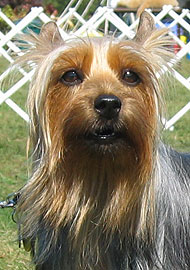

In [30]:
import numpy as np
import os
from PIL import Image
import random

data_dir = './dogImages/test'

file_list = os.listdir(data_dir)
breed = random.choice(file_list)
breed_dir = os.path.join(data_dir, breed)
img_dir = random.choice(os.listdir(breed_dir))

print(breed)
img = Image.open(os.path.join(breed_dir, img_dir))
img

In [31]:
np.array(img).shape

(270, 190, 3)

In [32]:
img_reshape = np.expand_dims(np.asarray(img).transpose(), axis=0).astype(np.float32)
img_reshape.shape

(1, 3, 190, 270)

In [33]:
# predict the image
response = predictor.predict(img_reshape)
print(np.argmax(response[0])+1)

42


The model is prediction the image as `42` but our image label is `127`.

Let's do little transformation and see if the result would change.

In [43]:
import torchvision.transforms as transforms

transform_valid = transforms.Compose([
        transforms.Resize(256), 
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            (0.497,0.402,0.425), (0.308, 0.325, 0.301)
        )
    ])

image_trans = transform_valid(img)[:3,:,:].unsqueeze(0).numpy()

In [44]:
# predict the image
response = predictor.predict(image_trans)
print(np.argmax(response[0])+1)

42


The model is still predicting the photo as `42`. The model needs to be trained more to increase the accuracy.

In [39]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: smdebugger-dog-bread-pytorch-test-2023-03-31-01-40-12-671
INFO:sagemaker:Deleting endpoint with name: smdebugger-dog-bread-pytorch-test-2023-03-31-01-40-12-671


The end of the notebook